In [19]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations, product, permutations

INITIAL_POPULATION_SIZE = 30

INITIAL_MINIPOPULATION_SIZE = 10

NUMBER_OF_POPULATIONS = 1

MIGRATION_CHANCE = 0.0005

PERCENT_OF_BEST_INDIVIDUALS = 0.6

MUTATION_CHANCE = 0.3

STEPS = 101

In [9]:
def get_data(file):
    with open(file, 'r') as fp:
        MAX_WEIGHT = int(fp.readline())
        next_line = fp.readline()
        values = [int(val.strip()) for val in next_line.split(",")]
        values = np.asarray(values)
        next_line = fp.readline()
        weights = [int(weight.strip()) for weight in next_line.strip().split(",")]
        weights = np.asarray(weights)
    return MAX_WEIGHT, values, weights
   

MAX_WEIGHT, values, weights = get_data('dataset')
print("max_value:", MAX_WEIGHT)
print("weights:", weights)
print("values:", values)

max_value: 200
weights: [ 7  3  5  7  9  1 18 12 12 19  1 18 12 13 16  6 17  6 15 16 10 10 10  6
 11 16 10  5  1 12  4 19  6  4 13  1 17 11  9 11]
values: [ 1 13 12 19  1  6  6 15  8  4  5 12 11 18  9  9 12 16  2  8 11  3  9 17
  2 16  2  5  3 17 11 10 13 18  2  7 13 11 10 16]


In [10]:
# Generate one or multiple populations each having multiple individuals represented as binary arrays 
# (ex: [1 0 1 1 0 1 0 0 ...]) of size equal to the number of items. The value of i-th element from an
# individual represents whether the object i is selected for knapsack (1) or not (0)

def generate_initial_populations(pop_sizes = INITIAL_POPULATION_SIZE, nr_pop = NUMBER_OF_POPULATIONS):
    populations = []
    for pop_index in range(0, nr_pop): 
        i = 0
        population = []
        while (i < pop_sizes):
            individual = np.random.randint(2, size=len(values))
            if (np.dot(individual, weights) <= MAX_WEIGHT):
                i+=1
                population.append(individual)
        populations.append(population)
    if (nr_pop == 1):
        return populations[0]
    else:
        return populations

In [11]:
# Change randomly values of individuals (1 -> 0, 0 -> 1)

def mutate(population, mutation_chance = MUTATION_CHANCE):
    for individual in population:
        if (np.random.uniform(0,1,1) < mutation_chance):
            index = random.randint(0,len(individual)-1)
            individual[index] = individual[index] * (-1) + 1
    return population

In [12]:
# Combine two individuals through a mask (binary array). If the value of i-th element of the mask is 1, 
# the generated individual will copy the i-th value from parent1, else it will be copied from parent2

def crossover (comb, population):
    random.shuffle(comb)
    crossover_pairs = comb[1:15]
    for i, j in crossover_pairs:
        mask = np.random.randint(2, size=len(population[1]))
        result = mask * population[i] + abs((mask - 1)) * population[j]
        population.append(result)
    return population

In [13]:
def fitness(individual):
    if (np.dot(individual, weights) <= MAX_WEIGHT):
        return np.dot(individual, values)
    else:
        return 0

In [14]:
# Sort individuals by fitness and choose best_individuals + random_individuals

def new_generation(population):
    population = sorted(population, key=lambda x: fitness(x), reverse=True)
    pop = population[0]
    best_score = np.dot(population[0], values)
    index = math.floor(PERCENT_OF_BEST_INDIVIDUALS * INITIAL_POPULATION_SIZE)
    good_individuals = population[:index]
    random.shuffle(population)
    random_individuals = population[:INITIAL_POPULATION_SIZE - index]
    new_generation = good_individuals + random_individuals
    return pop, best_score, new_generation

In [15]:
# Change an individual from a population with another individual from another population

def migrate(comb, populations):
    for elem1, elem2, index in comb:
        if (np.random.uniform(0,1,1) < MIGRATION_CHANCE):
            pop1_idx, pop2_idx = index
            z = np.copy(populations[pop1_idx][elem1])
            populations[pop1_idx][elem1] = np.copy(populations[pop2_idx][elem2])
            populations[pop2_idx][elem2] = np.copy(z)

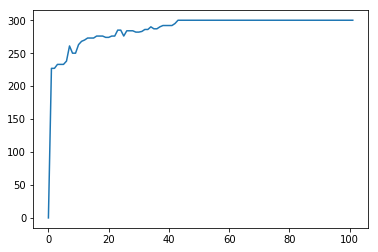

In [21]:
# GA with 1 population (no migrating populations)
population = generate_initial_populations()

# comb = all possible combinations between individuals
comb = list(combinations(list(range(INITIAL_POPULATION_SIZE - 1)), 2))

score = [0]

# mutation chance decreases with respect to number of steps performed
mutation_chances = np.linspace(MUTATION_CHANCE, 0.05, STEPS)
                               
for i in range(STEPS):
    pop_combined = crossover(comb, population)
    pop_mutated = mutate(pop_combined, mutation_chances[i])
    pop, best_score, population = new_generation(pop_mutated)
    score.append(best_score)
                               
plt.plot(score)

In [29]:
# Knapsack
val = len(values)
w = MAX_WEIGHT 
D = np.zeros((val,  w))
for i in range (1,val):
    for j in range (0,w):
        if(weights[i] > j):
            D[i, j] = D[i - 1, j]
        else:
            D[i, j] = max(D[i - 1, j], D[i-1, j - weights[i]] + values[i])            
print(D)
print("Optimal value for weight less than", MAX_WEIGHT, ":",  D[val-1][w-1])

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...  13.  13.  13.]
 [  0.   0.   0. ...  25.  25.  25.]
 ...
 [  0.   7.  13. ... 292. 295. 295.]
 [  0.   7.  13. ... 297. 297. 297.]
 [  0.   7.  13. ... 304. 304. 304.]]
Optimal value for weight less than 200 : 304.0


Max weight is  304
Runs: 2


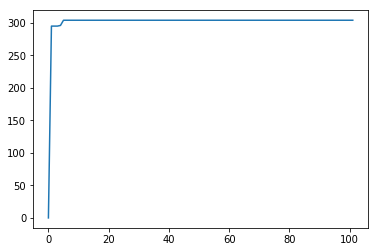

In [31]:
# Test how many runs are necessary for getting the optimal solution

population = generate_initial_populations()
comb = list(combinations(list(range(INITIAL_POPULATION_SIZE - 1)), 2))
score = [0]
cnt = 0
mutation_chances = np.linspace(MUTATION_CHANCE, 0.05, STEPS)

while max(score) < 304:
    score = [0]
    cnt+=1
    for i in range(STEPS):
        pop_combined = crossover(comb, population)
        pop_mutated = mutate(pop_combined, mutation_chances[i])
        pop, best_score, population = new_generation(pop_mutated)
        score.append(best_score)

print("Max weight is ", max(score))
print("Runs:", cnt)

plt.plot(score)


In [ ]:
# 4 populations with 10 individuals each. Each population goes through mutation and crossover proceeses. Moreover,
# any population can exchange individuals (migrate) with any other individuals from any other population

mini_pop_size = 10
mini_pop_number = 4

populations = generate_initial_populations(pop_sizes = mini_pop_size, nr_pop =  mini_pop_number)
i = list(range(INITIAL_POPULATION_SIZE - 1))
pop_index = list(range(NUMBER_OF_POPULATIONS - 1))
migration_indexes = list(permutations(pop_index, 2))
comb_migrate = list(product(i, i, migration_indexes))
comb_crossover = list(combinations(i, 2))

score = [0]
for i in range(STEPS):
    if (i%20 == 0):
        print ("Episode", i, "max", max(score))
    migrate(comb_migrate, populations)
    maxx = 0
    for population in populations:
        pop_combined = crossover(comb_crossover, population)
        pop_mutated = mutate(pop_combined)
        _, best_score, population = new_generation(pop_mutated)
        if (best_score > maxx):
            maxx = best_score
            score.append(best_score)
plt.plot(score)
print(max(score))